In [1]:
from sklearnex import patch_sklearn 

patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import tslearn as ts
import numpy as np
import module as mod

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Import et nettoyage des données

In [2]:
house2_power_blk1 = mod.load_dataset('data/house2_power_blk1_labels.zip')
house2_power_blk1.head()

,mains,activity,hour
datetime,,,
2017-09-12 23:00:00,103.0,0,23.0
2017-09-12 23:00:01,101.0,0,23.0
2017-09-12 23:00:02,104.0,0,23.0
2017-09-12 23:00:03,104.0,0,23.0
2017-09-12 23:00:04,105.0,0,23.0


In [3]:
all_windows = ['2min', '5min', '10min', '30min', '1h', '2h', '3h', '5h', '12h']

features_cols = []
for i, rolling_window in enumerate(all_windows):
    house2_power_blk1, cols = mod.generate_features(house2_power_blk1, window=rolling_window)
    features_cols += cols

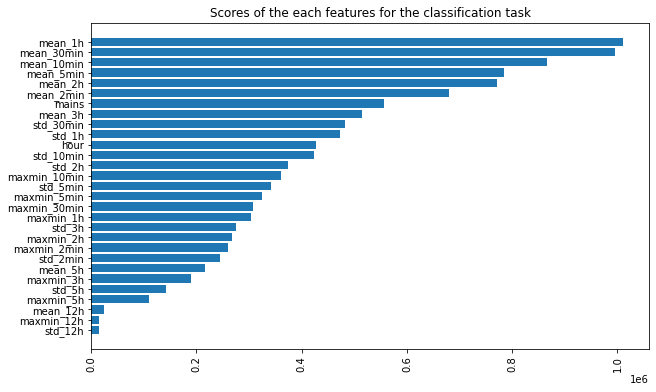

In [4]:
# ideally this would be done after a split test / train
fs = SelectKBest()
all_features = ['mains', 'hour'] + list(features_cols)
fs.fit_transform(house2_power_blk1.loc[:, all_features].values, house2_power_blk1.loc[:, 'activity'].values)

sorted_scores_idx = np.argsort(fs.scores_)
#features = np.array([str(i) for i in sorted_scores_idx])
fig = plt.figure(figsize=(10, 6))
plt.barh(y=np.array(all_features)[sorted_scores_idx], width=fs.scores_[sorted_scores_idx]);
#plt.bar(x=range(len(fs.scores_)), height=fs.scores_);
plt.xticks(rotation=90)
plt.title('Scores of the each features for the classification task');

Sur ce jeu de données 1 heure et 5 minutes semblent être les deux fenêtres optimales.

In [5]:
best_windows = ['1h', '5min']
features_col = ['mains', 'hour'] + [func+window for window in best_windows for func in ['std_', 'mean_', 'maxmin_']]

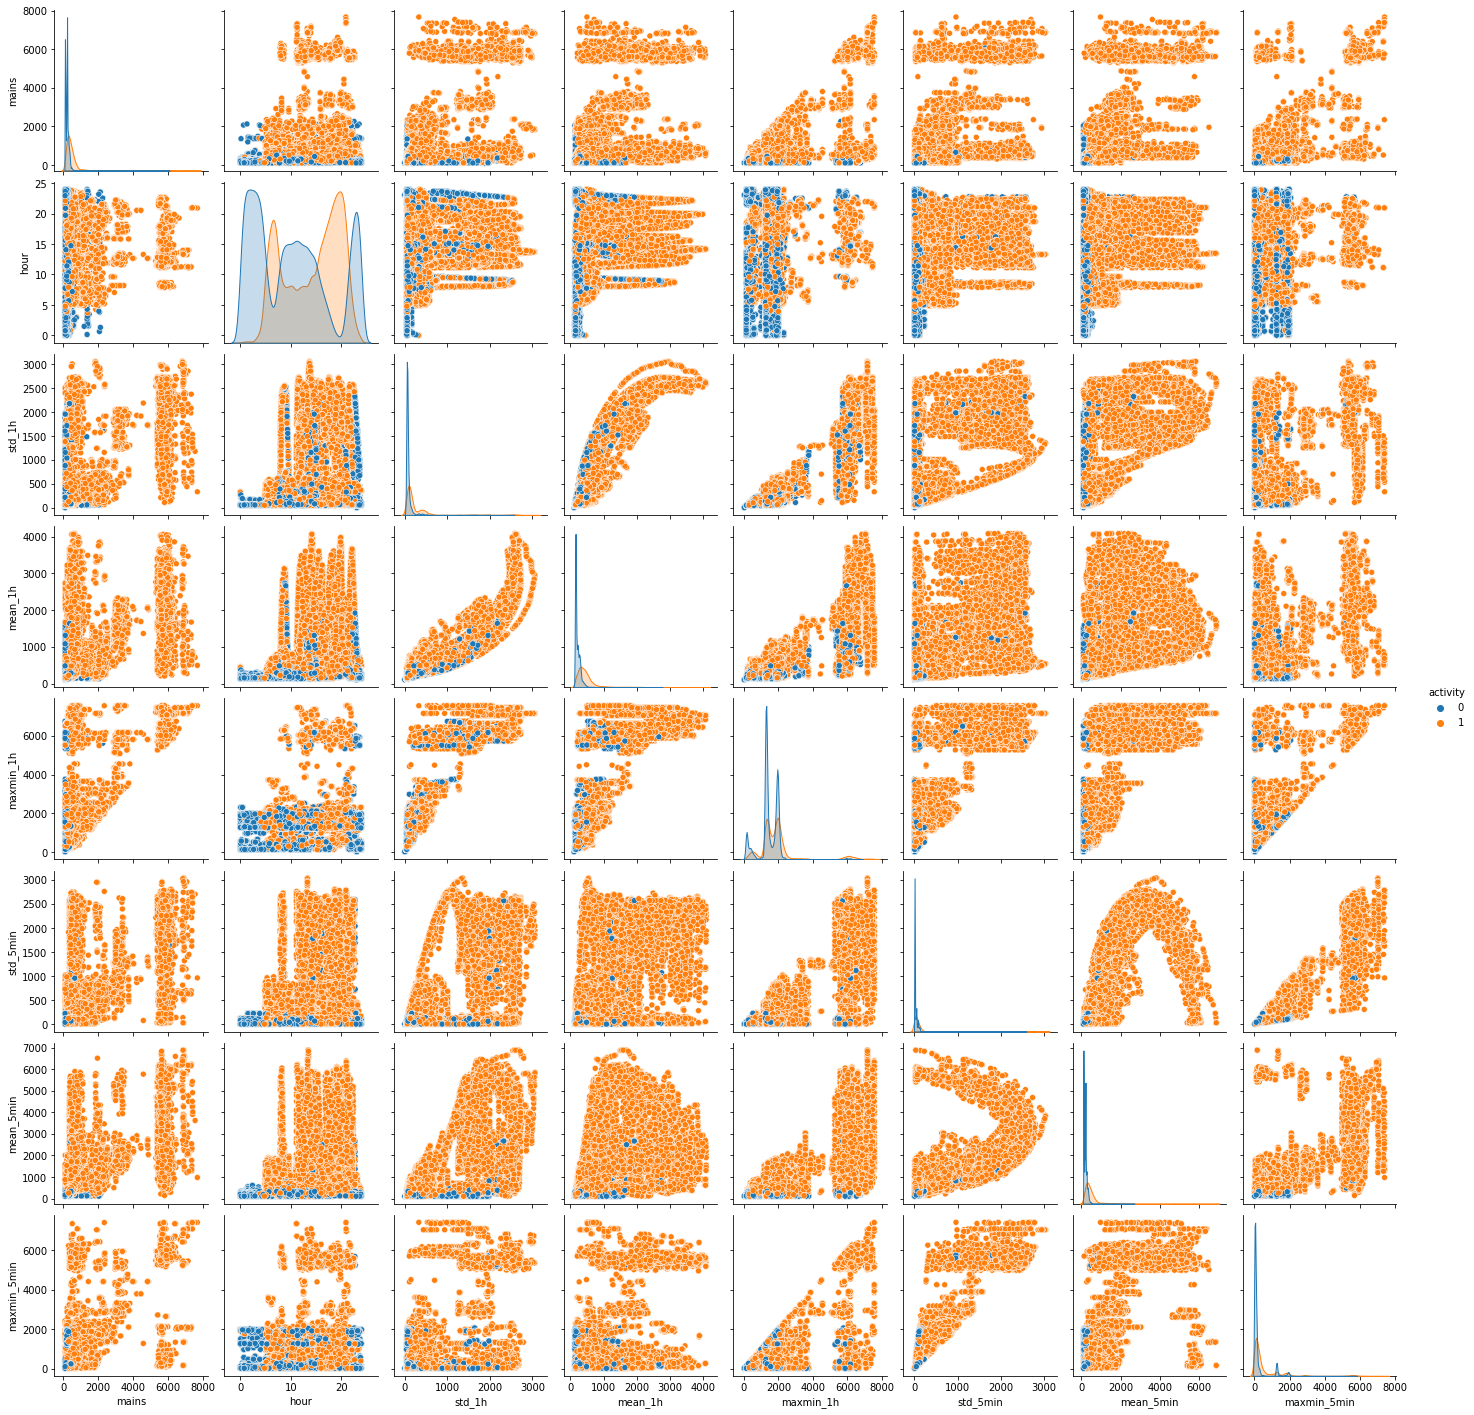

In [6]:
sns.pairplot(house2_power_blk1[features_col + ['activity']].sample(frac=0.1), hue='activity');

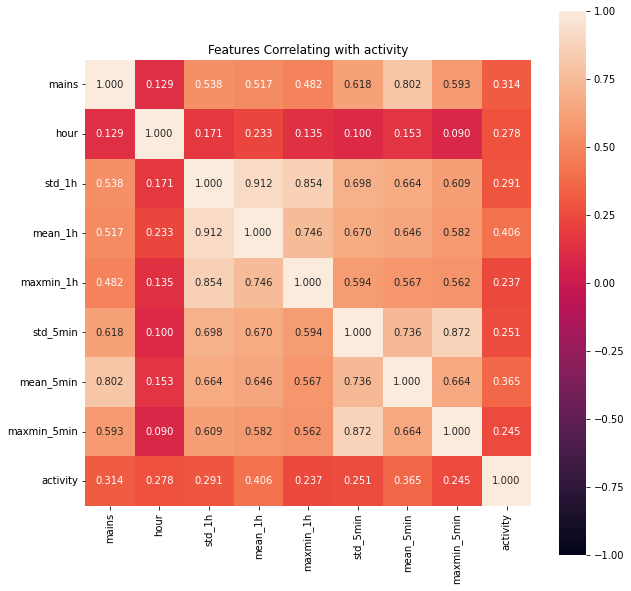

In [7]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(house2_power_blk1[features_col + ['activity']].corr(), vmin=-1, vmax=1, annot=True, fmt='.3f', square=True)
ax.set_title('Features Correlating with activity');

# 2. Train / test split

In [8]:
best_windows = ['1h', '5min']

features_col = ['mains', 'hour']
for window in best_windows:
    house2_power_blk1, cols = mod.generate_features(house2_power_blk1, window=window)
    features_col = ['mains', 'hour'] + cols
X_train, X_test, y_train, y_test = mod.split_train_test_scale_df(house2_power_blk1, features_col)

# 3. Algorithmes généraux

Score f_beta : 80.434%
Score accuracy : 80.679%


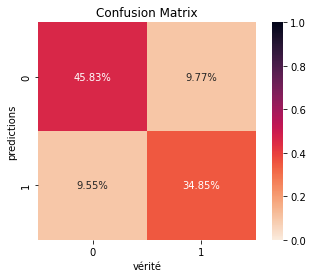

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
mod.plot_confusion_matrix(y_test, y_pred);

tested n_neighbors=1 ...
tested n_neighbors=30 ...
tested n_neighbors=60 ...
tested n_neighbors=90 ...


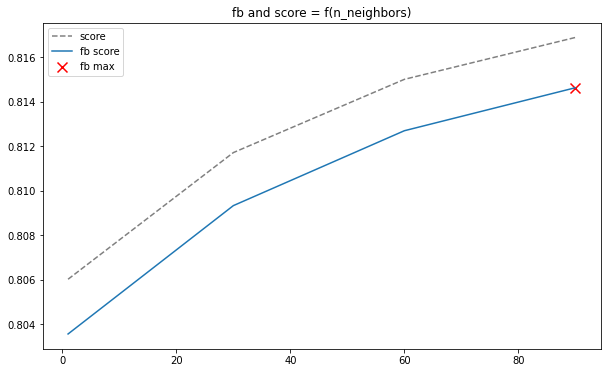

Meilleur fb score=0.81 obtenu pour n_neighbors=90.00
Score f_beta : 81.463%
Score accuracy : 81.689%


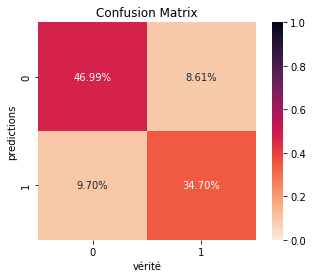

In [10]:
from sklearn.neighbors import KNeighborsClassifier

k_range = [1, 30, 60, 90]
mod.plot_scores_param(X_train, X_test, y_train, y_test, KNeighborsClassifier, 'n_neighbors', k_range);

tested n_estimators=1 ...
tested n_estimators=10 ...
tested n_estimators=20 ...
tested n_estimators=30 ...
tested n_estimators=40 ...
tested n_estimators=60 ...


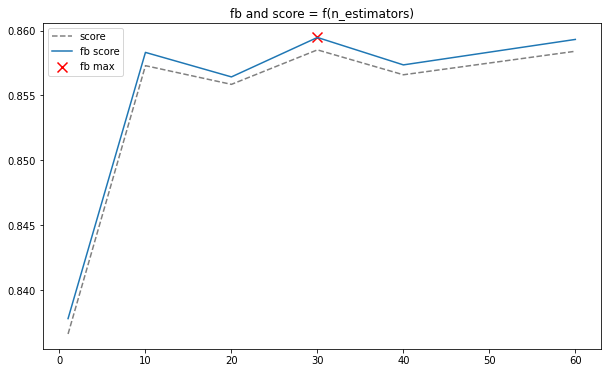

Meilleur fb score=0.86 obtenu pour n_estimators=30.00
Score f_beta : 83.517%
Score accuracy : 83.707%


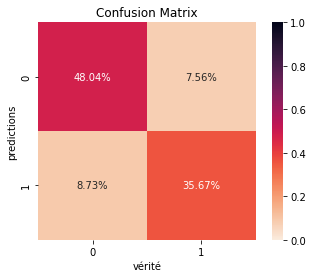

In [11]:
from sklearn.ensemble import RandomForestClassifier

n_range = [1, 10, 20, 30, 40, 60]
mod.plot_scores_param(X_train, X_test, y_train, y_test, RandomForestClassifier, 'n_estimators', n_range, other_params={'n_jobs': -1, 'max_samples': 0.8, 'max_depth': 10});

tested n_estimators=1 ...
tested n_estimators=5 ...
tested n_estimators=10 ...
tested n_estimators=20 ...


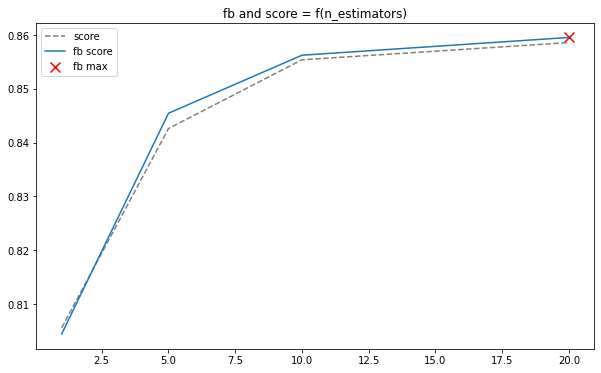

Meilleur fb score=0.86 obtenu pour n_estimators=20.00
Score f_beta : 85.123%
Score accuracy : 85.152%


('n_estimators', 20, 0.8585920479302832, 0.8595402984201805)

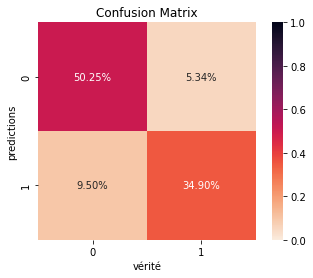

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

n_range = [1, 5, 10, 20]
mod.plot_scores_param(X_train, X_test, y_train, y_test, AdaBoostClassifier, 'n_estimators', n_range, other_params={'base_estimator': DecisionTreeClassifier(max_depth=2)})

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

n_range = [20, 40, 60, 80]
mod.plot_scores_param(X_train, X_test, y_train, y_test, HistGradientBoostingClassifier, 'max_depth', n_range, other_params={'max_iter': 300})